In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np


In [2]:
from DemoSuportLibrary import *

In [3]:
import os
from time import time

In [4]:
import tensorflow as tf

In [ ]:
print('hi')

In [5]:
FORCE_NORMILIZATION_FACTOR = 7000
YOUNGS_MODULUS_NORMILIZATION_FACTOR = 238000000000
COMPLIANCE_MAX_NORMILIZATION_FACTOR = 0.03
STRESS_MAX_NORMILIZATION_FACTOR = 15000000


<h1>Creating a part</h1>
<p>When creating a new part there are three design points you must consider: The placement of the circles, the direction of two forces, and what the constraints should be</p>
<p>For placing the circles, our domain allows for circles to be placed anywhere in a continuous 2 by 1 mesh as long as the circles do not overlap with each other or the boundaries of the domain. If a circle violates theses constraint then it will be altered till it best fits these conditions.</p>
<p>Since all three forces must sum to zero, users are only allowed to input two forces for the circles. The third force will automatically be generated to cancel out the other two. Forces are generated with polar coordinates so the user must select a magnitude and an angle. Valid force sizes are in the 10,000 kilo-newton range but you can go as high as 20,000 and may also go negative.</p>
<p>The constraints for the problem inlcude the Young's modulus, the compliance max and the stress max.</p>
<ul>
    <li>Young's modulus: min:5.2e+10 mean:2.9e+11 max:5e+11</li>
    <li>Compliance max: min:0.0006 mean:0.03, max:.5</li>
    <li>Stress max: min:3e+6 mean:1.5e+7 max:4.7e+7</li>
</ul>
<p2>It is important to note that these are all unitless values, while they do corespond to real units and react proportionally to each other, they do not represent a true scale.<\p2>

In [6]:
#current set up is the fidget spinner formation

#circle 1
c1_x = 0.85
c1_y = 0.76
c1_radius = .15

#circle 2
c2_x = 0.85
c2_y = 0.24
c2_radius = .15

#circle 3
c3_x = 1.3
c3_y = 0.5
c3_radius = .15

In [ ]:
#urrent set up is presolved iteration
#circle 1
c1_x = .67
c1_y = 0.75
c1_radius = .2

#circle 2
c2_x = 1.0
c2_y = 0.25
c2_radius = .15

#circle 3
c3_x = 1.4
c3_y = .6
c3_radius = .15

In [7]:
# standard resolution is 100 by 50

circles_array = np.array([[c1_x,c2_x,c3_x],[c1_y,c2_y,c3_y]])
radii_array = np.array([c1_radius,c2_radius,c3_radius])

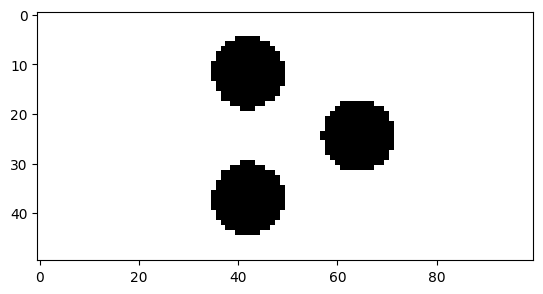

In [8]:
#check the current shape of the circles

x = np.linspace(0,2,100)
y = np.linspace(0,1,50)
X,Y = np.meshgrid(x,y)

def dist(num):
    return np.sqrt((X-circles_array[0][num])**2 + (Y-circles_array[1][num])**2) - radii_array[num]

circleImage = np.minimum(dist(0),np.minimum(dist(1),dist(2)))
circleImage = np.where(circleImage >= 0, 0,1)

plt.imshow(circleImage,cmap='gray_r')

In [9]:
#forces are set to the mean value pointed at an angle
force1 = 1e4
angle1 = (1/6)*np.pi

force2 = 1e4
angle2 = (5/6)*np.pi

In [10]:
#code to create true force vectors
def genForces(f1,a1,f2,a2):
    fx_1 = f1*np.cos(a1)
    fy_1 = f1*np.sin(a1)
    fx_2 = f2*np.cos(a2)
    fy_2 = f2*np.sin(a2)

    fx_3 = -(fx_1+fx_2)
    fy_3 = -(fy_1+fy_2)

    print("forces are:")
    print("Force1: x={}, y={}".format(int(fx_1),int(fy_1)))
    print("Force2: x={}, y={}".format(int(fx_2),int(fy_2)))
    print("Force3: x={}, y={}".format(int(fx_3),int(fy_3)))

    return np.array([[fx_1,fx_2,fx_3],[fy_1,fy_2,fy_3]])

In [11]:
forces = genForces(force1,angle1,force2,angle2)

forces are:
Force1: x=8660, y=4999
Force2: x=-8660, y=4999
Force3: x=0, y=-9999


In [12]:
#slightly higher constraints than normal

YoungsModulus = 3e11
ComplianceMax = 0.05
StressMax = 2e7

#standard resolution
nelx = 100
nely = 50

formattedVector = [circles_array,radii_array,forces,nelx,nely,YoungsModulus,ComplianceMax,StressMax]

In [ ]:
forces = np.array([[15000,0,-15000],[5000,-10000,5000]])


YoungsModulus = 2e11
ComplianceMax = 1e-2
StressMax = 3e7

#standard resolution
nelx = 100
nely = 50

formattedVector = [circles_array,radii_array,forces,nelx,nely,YoungsModulus,ComplianceMax,StressMax]

In [13]:
def getModel(modelNum):
    #modelNum = 9
    model = Model_m9()
    fileSaveName = "Model_m{}".format(modelNum)
    
    

    modelPath = os.path.join(os.getcwd(),'ModelSave',fileSaveName)
    
    if(os.path.isdir(modelPath)):
        try:
            
            model.load_weights(os.path.join(modelPath,fileSaveName))
        except:
            print("Model weights could not be loaded.")
        else:
            print("Model weights Loaded")
    else:
        os.mkdir(modelPath)
        print("Model path created")

    
    
    #model.compile(  optimizer='Adam', loss= tf.keras.losses.BinaryCrossentropy())
    return model

In [14]:
def formatDataForModel(formatVector):
    circles = formatVector[0]
    radii = formatVector[1]
    forces = formatVector[2]
    nelx, nely = formatVector[3], formatVector[4]
    Youngs, C_max, S_max = formatVector[5], formatVector[6], formatVector[7]

    x = np.linspace(0,2,nelx+1)
    y = np.linspace(0,1,nely+1)
    X,Y = np.meshgrid(x,y)

    def dist(num):
        return np.sqrt((X-circles[0][num])**2 + (Y-circles[1][num])**2) - radii[num]

    circleImage = np.minimum(dist(0),np.minimum(dist(1),dist(2)))
    circleImage = np.where(circleImage >= 0, 0,1)

    circleImage = np.reshape(circleImage.T,(nelx+1,nely+1,1))

    res = min(nelx,nely)

    forceImageX = np.zeros((nelx+1,nely+1,1))
    forceImageY = np.zeros((nelx+1,nely+1,1))
    for i in range(3):
        fx = forces[0][i] / FORCE_NORMILIZATION_FACTOR
        fy = forces[1][i] / FORCE_NORMILIZATION_FACTOR
        x_coord = int(circles[0][i] * res)
        y_coord = int(circles[1][i] * res)
        forceImageX[x_coord,y_coord,0] = fx
        forceImageY[x_coord,y_coord,0] = fy

        
    #print("Y.shape:",Y.shape)

    Y_image = (Youngs / YOUNGS_MODULUS_NORMILIZATION_FACTOR )*np.ones((nelx+1,nely+1,1))
    c_max_image = (C_max / COMPLIANCE_MAX_NORMILIZATION_FACTOR )*np.ones((nelx+1,nely+1,1))
    s_max_image = (S_max / STRESS_MAX_NORMILIZATION_FACTOR )*np.ones((nelx+1,nely+1,1))

    # print("circleImage.shape:",circleImage.shape)
    # print("forceImageX.shape:",forceImageX.shape)
    # print("forceImageY.shape:",forceImageY.shape)
    # print("Y_image.shape:",Y_image.shape)
    # print("c_max_image.shape:",c_max_image.shape)
    # print("s_max_image.shape:",s_max_image.shape)

    loadCondtionsImage = np.concatenate([circleImage,forceImageX,forceImageY,Y_image,c_max_image,s_max_image],axis=2)
    startBlock = np.ones((1,nelx+1,nely+1,1))

    loadCondtionsImage = np.reshape(loadCondtionsImage,(1,nelx+1,nely+1,6))
    return loadCondtionsImage,startBlock


In [15]:
#get the model set up
model_mass = getModel(9)
#model_comliance = getModel(8)

concat shapes (None, 26, 14, 64) and (None, 26, 13, 64) create padding 0 and 1
concat shapes (None, 52, 26, 32) and (None, 51, 26, 32) create padding 1 and 0
concat shapes (None, 102, 52, 64) and (None, 101, 51, 16) create padding 1 and 1
Model weights Loaded


In [16]:
#predict some iterations
formattedImage,StartingBlock = formatDataForModel(formattedVector)
PredictedImages = []
numImages = 200
ImageToPredict = StartingBlock


start = time()
for i in range(numImages):
    #use the output of the last iteration as the input for the next iteraion
    output = model_mass.predict({'x':ImageToPredict,'loadConditions':formattedImage},verbose=0)
    ImageToPredict = output#[0]
    PredictedImages.append(ImageToPredict)
end = time()
print("{} iterations took {:.2f} seconds or about {:.5f} seconds per iteration.".format(numImages,end-start,(end-start)/numImages))

200 iterations took 22.53 seconds or about 0.11263 seconds per iteration.


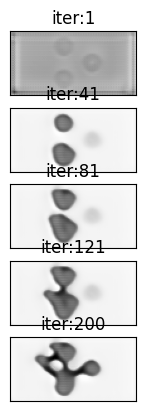

In [17]:
#show a subset of the predicted images
imagesToShow = 5
imagesToJump = numImages // imagesToShow

#create plot
fig,ax = plt.subplots(imagesToShow,1)
for i in range(0,imagesToShow-1):
    #for each image get the corisponding prediction
    ax[i].imshow(np.reshape(PredictedImages[i*imagesToJump],(nelx+1,nely+1)).T,cmap='gray_r',norm=colors.Normalize(vmin=0,vmax=1))

    #clear the plot of exess detail
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    # set the correct plot title
    ax[i].set_title("iter:{}".format(i*imagesToJump + 1))

#always show the final iteration
ax[-1].imshow(np.reshape(PredictedImages[-1],(nelx+1,nely+1)).T,cmap='gray_r',norm=colors.Normalize(vmin=0,vmax=1))
ax[-1].get_xaxis().set_visible(False)
ax[-1].get_yaxis().set_visible(False)
ax[-1].set_title("iter:{}".format(numImages))

plt.show()


In [ ]:
np.save("modeloutput",PredictedImages[-1])

In [ ]:
print(np.reshape(PredictedImages[-1],(101*51),order='F'))